# 📧 **Ejercicio de clasificación: detección de spam**

Autores:
* **[Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR)**
* **[Elías Robles Ruiz](https://github.com/eliasrrobles)**

Dataset: **[Spam Mails Dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset/data?select=spam_ham_dataset.csv)**

Repositorio: **[GitHub](https://github.com/Alejandro-BR/Detection-Spam)**

Máster de FP en Inteligencia Artifical y Big Data - CPIFP Alan Turing


## Imagen general

El proyecto trata de construir un modelo de Machine Learning capaz de clasificar si un email es spam o no.

## Importaciones

In [243]:
import re
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer # Hemos optado por lematizar en vez del stemming para no perder
from nltk.corpus import wordnet, stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Descargas de NLTK

In [244]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Obtención de datos
**Fuente:** [Spam Mails Dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset/data?select=spam_ham_dataset.csv)

Parte de los emails `ham` (no spam) proviene del **Enron Corpus**, una base de datos pública de correos reales de empleados de la empresa Enron.

In [245]:
path = kagglehub.dataset_download("venky73/spam-mails-dataset")
file_path = os.path.join(path, "spam_ham_dataset.csv")

Using Colab cache for faster access to the 'spam-mails-dataset' dataset.


In [246]:
emails_df = pd.read_csv(file_path)

## Descripción de los datos

El dataset cuenta con 4 columnas y 5171 filas.

El target que se busca predecir es `label_num`, es decir, si un correo es `spam = 1` o `ham = 0`.

| Columnas | Tipo de dato | Descripción |
| :----- | :----- | :----- |
| Unnamed: 0 | int64 | Indice antiguo (desconocido) |
| label | object | `spam` / `ham` |
| text | object | Cuerpo del email |
| label_num | int64 | `spam` = 1 / `ham` = 0 |


In [247]:
emails_df.info()

emails_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


## Exploración y visualización de los datos

Se realizará un estudio de los datos, mostrando gráficas, observando si hay valores nulos, etc.

In [248]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


Vamos a comprobar si el dataset contiene valores nulos:



In [249]:
emails_df.info()
print("\n", "-" * 37)
emails_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB

 -------------------------------------


,0
Unnamed: 0,0
label,0
text,0
label_num,0


Como podemos ver el dataset no cuenta con ningún valor nulo.

Ahora vamos a ver qué porcentaje de los correos son spam y cuáles no.

In [250]:
spam_count = emails_df["label"].value_counts()["spam"]
ham_count = emails_df["label"].value_counts()["ham"]

print(f"SPAM: {spam_count} | HAM: {ham_count}")

SPAM: 1499 | HAM: 3672


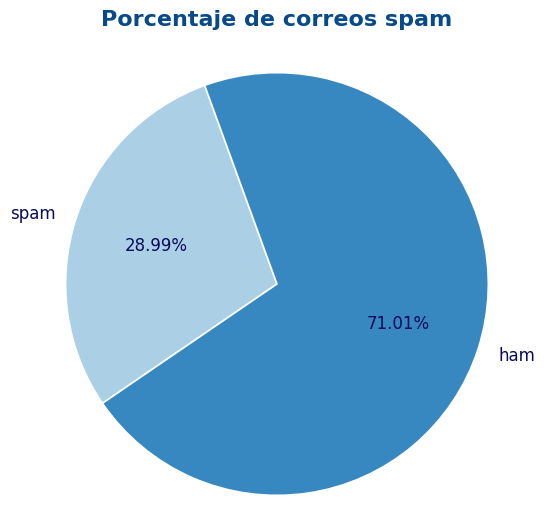

In [251]:
labels = ["spam", "ham"]
sizes = [spam_count, ham_count]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    sizes,
    labels=labels,
    autopct="%1.2f%%",
    startangle=110,
    colors=colors,
    textprops={"color": "#0A0A5A", "fontsize": 12},
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"}
)

ax.set_title(
    "Porcentaje de correos spam",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

ax.axis("equal")

plt.show()

Podemos observar que el 71% de los emails no son spam y solo el 29% lo son.

## Preparación de los datos para los algoritmos de Machine Learning

En este apartado vamos a limpiar el dataset para dejarlo listo para los modelos que elijamos.

Primero vamos a eliminar las columnas que no necesitamos, como el índice antiguo `Unnamed: 0` y el `label`.

In [252]:
emails_df.drop(["Unnamed: 0", "label"], axis=1,inplace=True)

Ahora vamos a modificar el nombre de nuestra columna target `label_num`, que ahora se llamará `is_spam`.

In [253]:
emails_df.rename(columns={"label_num" : "is_spam"}, inplace=True)

Ya tenemos el dataset con las columnas que queremos.

In [274]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     5171 non-null   object
 1   is_spam  5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


In [254]:
emails_df.head()

,text,is_spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


Vamos a indicar cuáles son las stopwords y a habilitar el lematizador.

In [255]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

Definimos las etiquetas para los tokens.

In [256]:
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

Función para limpiar y lematizar el texto.

In [257]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http[s]?://\S+|www\.", " ", text) # Regex para quitar urls
    text = re.sub(r"\d+", " ", text)            # Quitar números
    text = re.sub(r"[^a-zA-Z\s]", " ", text)    # Quitar simbolos y puntuaciones
    text = re.sub(r"\s+", " ", text).strip()    # Quitar espacios extra añadidos

    return tokenize(text)

In [258]:
def tokenize(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)

    return " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                        for word, tag in tags if word not in stop_words])


Aplicamos la limpieza y tokenización de los textos.

In [259]:
emails_df["text"] = emails_df["text"].apply(clean_text)

Preparamos el **vectorizado**, al final vamos a usar el `TfidfVectorizer` al cual vamos a personalizarlo usando distintos parametros.

In [260]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # Aceptar unigramas y bigramas como "free" y "free money"
    max_df = 0.9,           # Ratio máximo de aparición para ser contabilizado en el diccionario
    min_df = 2,             # Ratio mínimo de aparición para ser añadida al diccionario
    max_features = 5000,    # Tamaño máximo del diccionario
    dtype = np.float32,     # Formato
    sublinear_tf = True     # Cambia la forma de contar las aparaciones para evitar distorsiones pasa de lineal a logarítmica
)

### Particiones para entrenamiento y prueba

En este subapartado se dividirá el dataset en $X$ y $y$, y posteriormente en sus dos subconjuntos de entrenamiento y prueba.

Y en sus dos sub divisiones para entrenamiento y pruebas.

* $X$: `text` tokenizado.

* $y$: Nuestro target `is_spam`.

In [261]:
X = tfidf.fit_transform(emails_df["text"])
y = emails_df["is_spam"]

In [264]:
# Se quita el límite de columnas, permitiendo visualizar todas
pd.set_option('display.max_columns', None)
pd.set_option("display.expand_frame_repr", False)

In [262]:
X_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
X_df.head()


aa  ability  able  able get  absence  absolutely   ac  accept  acceptance  acceptance term  access  accessory  accomplish  accord  accordingly  account  account arrangement  accountant  accounting  accounting arrangement  accounting investment  accuracy  accuracy completeness  accurate  achieve  acquire  acquisition  acre  across  act  act section  act statement  action  action may  active  activity  activity allocation  activity meter  acton  acton corp  actual  actual flow  actual result  actual vols  actual volume  actualize  actually  actuals  actuals august  actuals july  actuals june  actuals november  actuals october  actuals sept   ad  adam  adapter  add  add deal  addition  additional  additional information  additionally  additionally producer  address  address browser  adipren  adjust  adjustment  admin  administration  administrative  adobe  adobe illustrator  adobe photoshop  adonis  adult  advance  advanced  advantage  advertisement  advertising  advice  advice reference  advice registered  advise  advise reader  advise thanks  advisor  aeor  aeor contact  aep  aep com  aepin  aepin aepin  aerofoam  affect  affiliate  affordable  africa  afternoon  age  agency  agency agreement  agency fee  agenda  agent  aggressive  ago     agree  agree eileen  agreement  agreement carthage  agua  agua dulce  ahead  aid  ail  aim  aimee  aimee forward  aimee lannou  air  airline  airmail  airmail net   al  albrecht  albrecht well  alcohol  alert  ali  ali duty  align  align center  alland  allen  allen hou  allocate  allocate stranger  allocation  allocation exception     allow  almost  alone  along  alpine  already      also  also need  alt  alt rnd  alternative  although  always  amazon  amazon com  ambien  amelia  amelia alland  amend  america  america corp  american  ami  ami chokshi  among  amount  amy  analysis  analyst  anderson  andrew  angeles  anita  anita luong  ann  announce  announcement  announces  annual  another    answer  answer question  anthony  anti  anticipate  anticipate forward  anticipates  antivirus  anxiety  anyone  anyone else  anything  anything else  anytime  anyway  anywhere   ao  aol  aol com  aopen  aopen creative  apache  apc  apc cisco  apparently  appear  apple  applicable  application  apply  appointment  appreciate  approach  appropriate  approval  approval write  approval writeoff  approve  approx  approximately  apr  april  april may  april pm  april see  april th  aquila   ar  archer  archer fuel  area  arial  arise  arm  armstrong    around  around world  arrange  arrangement  arrive  art  artprice      asap  ascii  ask  ask question  asp  aspect  asset  assign  assignment  assist  assistance  assistant  associate  association  assume  assumption  assumption future  assurance  assurance happen  assure  atleast  att  att net    attach  attach file  attach gathering  attach spreadsheet  attached  attached file  attached spreadsheet  attachment  attack  attempt  attend  attention  auction  audio  audit  aug  august  august pm  august see  august teco  austin  austin hou  australia  authority  auto  automatically  avail  availability  availability subject  available  average  avila  avila lsp  avoid  award  aware  aware inherent      away  awesome   ba  baby      back  back guarantee  background  backout  bad  baker  balance  ball  bammel  bane  bane easttexas  bank  bank account  banking  bankruptcy  bar  barrett  base  base expectation  base following  base gas  base information  baseload  basin  basin production  basis  basis deal  bass  batch   battery  baumbach  baumbach david  baumbach hou  bav  baxter  baxter hou  bay   bb  beach  bear  beaty  beaty hou  beaumont  beaumont methanol  beauty  beck  beck hou  becky  become  bed  beemer  begin  begin month  beginning  behalf  behind  beliefs  beliefs plan  believe  believe understands  belize  bellamy  bellamy enron  belong  benedict  benedict hou  beneficiary  benefit  benoit  benoit reliantenergy  best  best regard  beth  beverly  beverl

Separamos el dataset en dos partes:

* Datos de entranamiento (training set): 80%
* Datos de prueba (test set): 20% (si tenemos muchos datos, el porcentaje seria menor)

Además, utilizaremos `random_state = 777` para que en todos los entrenamientos y momentos los conjuntos de entrenamiento y prueba sean siempre los mismos.

In [263]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 777
)

## Exposición del objetivo

Nuestro objetivo es averiguar si un email es spam o no, mediante nuestro target que sera la `is_spam` mediante un clasificador.

## Entrenamiento del modelo y comprobación del rendimiento

En este apartado se entrenarán varios modelos, comprobando en cada caso el rendimiento que ofrecen mediante las apropiadas medidas de error y/o acierto.

Vamos a probar varios modelos supervisados de clasificación para determinar cuál nos da el mejor resultado.

* MultinomialNB
* BernoulliNB
* LogisticRegression
* LinearSVC
* RandomForestClassifier
* KNeighborsClassifier


In [265]:
model_nb_multinominal = MultinomialNB()
model_nb_bernoulli = BernoulliNB()
model_lr_classifier = LogisticRegression(max_iter=1000)
model_svm = LinearSVC()
model_rf_classifier = RandomForestClassifier(n_estimators=100)
model_knn = KNeighborsClassifier(n_neighbors=5)

Para evaluar los modelos, utilizaremos la siguiente función.

In [266]:
def test_model(y_pred, title):
  print(title)

  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}\n")

  print("Reporte de clasificación:")
  print(classification_report(y_test, y_pred, digits=4))

  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(6,5))
  sns.heatmap(
      cm,
      annot=True,
      fmt="d",
      cmap="Blues",
      xticklabels=["ham", "spam"],
      yticklabels=["ham", "spam"]
  )

  plt.ylabel("Etiqueta real")
  plt.xlabel("Predicción")
  plt.title(f"Matriz de Confusión - {title}")
  plt.show()


### Probar modelos:

MultinomialNB
Accuracy: 0.9420

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9828    0.9344    0.9580       732
           1     0.8584    0.9604    0.9065       303

    accuracy                         0.9420      1035
   macro avg     0.9206    0.9474    0.9323      1035
weighted avg     0.9464    0.9420    0.9429      1035



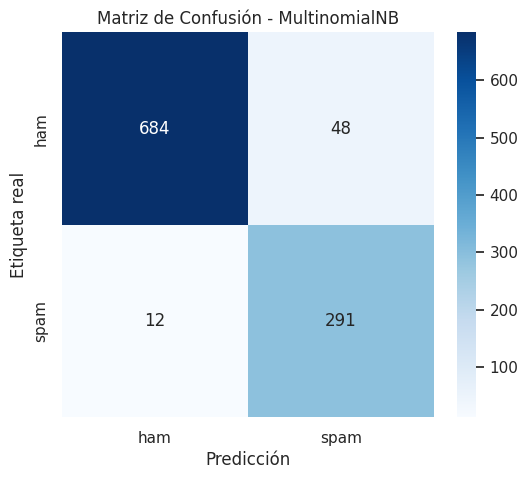

In [267]:
model_nb_multinominal.fit(X_train, y_train)
y_pred = model_nb_multinominal.predict(X_test)
test_model(y_pred, "MultinomialNB")

BernoulliNB
Accuracy: 0.9391

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9799    0.9331    0.9559       732
           1     0.8550    0.9538    0.9017       303

    accuracy                         0.9391      1035
   macro avg     0.9175    0.9434    0.9288      1035
weighted avg     0.9434    0.9391    0.9400      1035



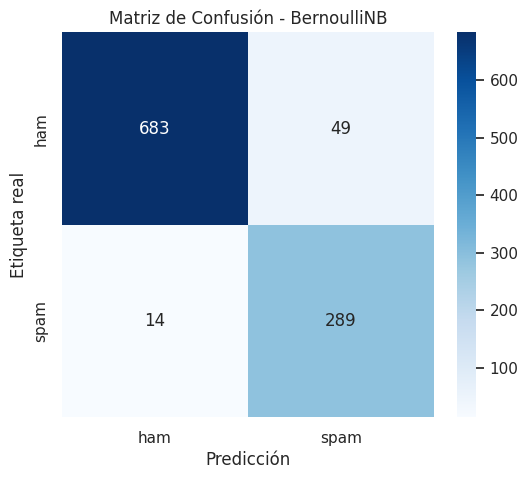

In [268]:
model_nb_bernoulli.fit(X_train, y_train)
y_pred = model_nb_bernoulli.predict(X_test)
test_model(y_pred, "BernoulliNB")

LogisticRegression
Accuracy: 0.9826

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9864    0.9891    0.9877       732
           1     0.9734    0.9670    0.9702       303

    accuracy                         0.9826      1035
   macro avg     0.9799    0.9780    0.9790      1035
weighted avg     0.9826    0.9826    0.9826      1035



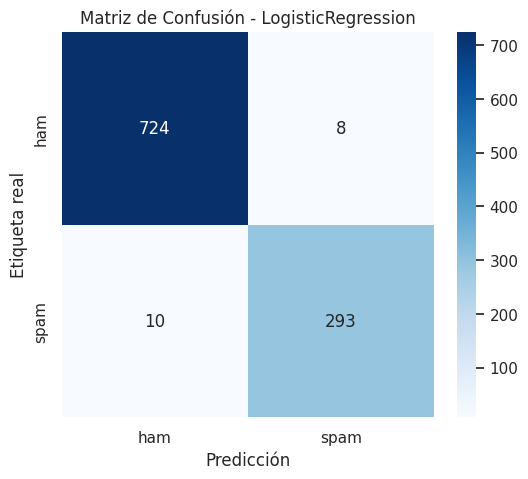

In [269]:
model_lr_classifier.fit(X_train, y_train)
y_pred = model_lr_classifier.predict(X_test)
test_model(y_pred, "LogisticRegression")

LinearSVC
Accuracy: 0.9865

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9931    0.9877    0.9904       732
           1     0.9707    0.9835    0.9770       303

    accuracy                         0.9865      1035
   macro avg     0.9819    0.9856    0.9837      1035
weighted avg     0.9866    0.9865    0.9865      1035



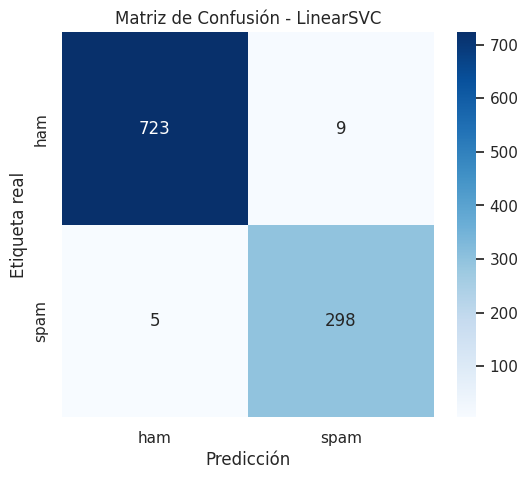

In [270]:
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
test_model(y_pred, "LinearSVC")

RandomForestClassifier
Accuracy: 0.9787

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9958    0.9740    0.9848       732
           1     0.9404    0.9901    0.9646       303

    accuracy                         0.9787      1035
   macro avg     0.9681    0.9821    0.9747      1035
weighted avg     0.9796    0.9787    0.9789      1035



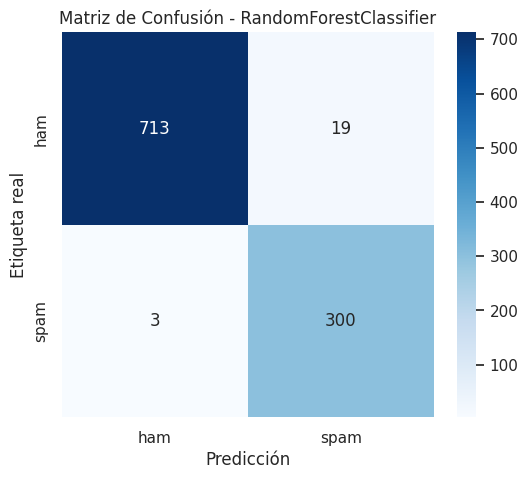

In [271]:
model_rf_classifier.fit(X_train, y_train)
y_pred = model_rf_classifier.predict(X_test)
test_model(y_pred, "RandomForestClassifier")

KNeighborsClassifier
Accuracy: 0.5710

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9966    0.3948    0.5656       732
           1     0.4054    0.9967    0.5763       303

    accuracy                         0.5710      1035
   macro avg     0.7010    0.6958    0.5709      1035
weighted avg     0.8235    0.5710    0.5687      1035



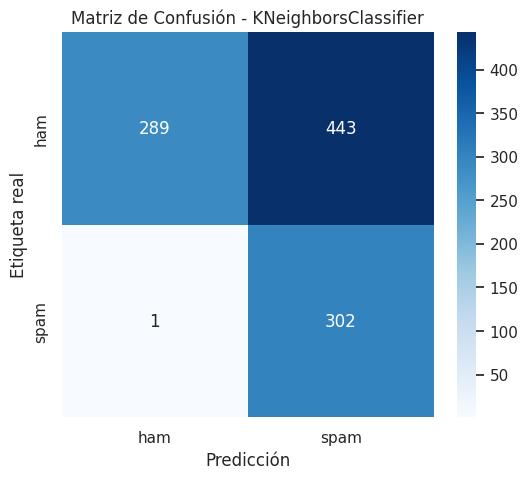

In [272]:
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
test_model(y_pred, "KNeighborsClassifier")

## Conclusiones

## **Bibliografía**

* [datacamp.com](https://www.datacamp.com/es/tutorial/stemming-lemmatization-python)

* [scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)




### **¿Como hemos elegido que vectorizador usar?**

* [medium.com](https://medium.com/@shandeep92/countvectorizer-vs-tfidfvectorizer-cf62d0a54fa4)

* [kaggle.com](https://www.kaggle.com/code/zeeshanlatif/countvectorizer-vs-tfidfvectorizer)

#### **Tabla comparativa**
Le preguntamos a *ChatGPT* cual deberiamos usar y nos respondio con esta tabla de pros y contras.

| Característica                  | CountVectorizer | TF-IDF Vectorizer  |
| ------------------------------- | --------------- | ------------------ |
| Cuenta palabras                 | ✔️              | ✔️ pero ponderadas |
| Penaliza palabras comunes       | ❌               | ✔️                 |
| Resalta palabras raras          | ❌               | ✔️                 |
| Evita que textos largos dominen | ❌               | ✔️                 |
| Mejor para clasificación        | A veces         | ✔️ casi siempre    |
| Valor en celdas                 | Enteros         | Decimales          |